In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [1]:
import numpy as np
import pandas as pd

In [29]:
df = pd.read_csv('/kaggle/input/banksim1/bs140513_032310.csv')

In [30]:
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


**Preprocessing**

In [31]:
# 1. First remove all single quotes from the age column
df['age'] = df['age'].str.replace("'", "")

# 2. Convert to numeric (this will turn any remaining non-numeric values to NaN)
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df = df.dropna(subset=['age'])  # Remove rows where 'age' is NaN

In [32]:
df['age'] = df['age'].astype(int)
# Remove quotes if gender values have them (e.g., "'M'" → "M")
df['gender'] = df['gender'].str.replace("'", "", regex=False)

# Now encode
df['gender_encoded'] = df['gender'].map({'M': 1, 'F': 0})

# Encode category (e.g., label encoding or one-hot)
df['category_encoded'] = df['category'].astype('category').cat.codes

In [33]:
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud,gender_encoded,category_encoded
0,0,'C1093826151',4,M,'28007','M348934600','28007','es_transportation',4.55,0,1.0,12
1,0,'C352968107',2,M,'28007','M348934600','28007','es_transportation',39.68,0,1.0,12
2,0,'C2054744914',4,F,'28007','M1823072687','28007','es_transportation',26.89,0,0.0,12
3,0,'C1760612790',3,M,'28007','M348934600','28007','es_transportation',17.25,0,1.0,12
4,0,'C757503768',5,M,'28007','M348934600','28007','es_transportation',35.72,0,1.0,12


**Feature Engineering**

In [34]:

# Transaction frequency and fraud count per customer
df['transaction_count_by_customer'] = df.groupby('customer')['amount'].transform('count')
df['fraud_count_by_customer'] = df.groupby('customer')['fraud'].transform('sum')

# Amount statistics per customer
df['amount_mean_by_customer'] = df.groupby('customer')['amount'].transform('mean')
df['amount_max_by_customer'] = df.groupby('customer')['amount'].transform('max')
df['amount_min_by_customer'] = df.groupby('customer')['amount'].transform('min')

# Amount × category interaction
df['amount_x_category'] = df['amount'] * df['category_encoded']


**Drop Raw Identifiers**

In [35]:
df = df.drop(columns=['customer', 'merchant', 'zipcodeOri', 'zipMerchant', 'gender', 'category'])


**Define Features & Labels**

In [36]:
X = df.drop(columns=['fraud'])
y = df['fraud']


**Handle Imbalance**

In [42]:
print(X_train.isnull().sum())


step                             0
age                              0
amount                           0
gender_encoded                   0
category_encoded                 0
transaction_count_by_customer    0
fraud_count_by_customer          0
amount_mean_by_customer          0
amount_max_by_customer           0
amount_min_by_customer           0
amount_x_category                0
dtype: int64


In [46]:
# Fill NaNs in gender_encoded with the mode (most common value)
X['gender_encoded'] =X['gender_encoded'].fillna(X['gender_encoded'].mode()[0])


In [47]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# SMOTE oversampling
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)


**Model and Evaluation**

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    175882
           1       0.73      0.84      0.78      2158

    accuracy                           0.99    178040
   macro avg       0.86      0.92      0.89    178040
weighted avg       0.99      0.99      0.99    178040

[[175216    666]
 [   341   1817]]
AUC: 0.9958079503847148


**Feature Importance**

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9981    0.9962    0.9971    175882
           1     0.7318    0.8420    0.7830      2158

    accuracy                         0.9943    178040
   macro avg     0.8649    0.9191    0.8901    178040
weighted avg     0.9948    0.9943    0.9945    178040



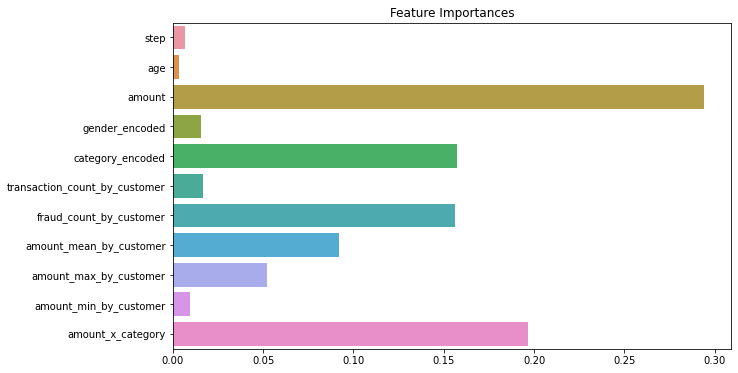

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances")
plt.show()
